# Google Cloud Parallel Data Read Speeds with Dask - Local Cluster

This benchmarking was inspired by the [Abernathey et al. (2021)](https://www.computer.org/csdl/magazine/cs/2021/02/09354557/1reXu4gJjri) paper, which includes a detailed analysis and discussion of cloud-native big scientific data. It is recommended that a reader unacclimated with this subject matter first studies its information before going through this notebook.

Unfortunately, due to the access token required to retrieve data the Google Cloud Storage Bucket used in this benchmarking, the public reader will not be able to run this notebook on their own. If you wish to download your own copy and alter the code, the test data from [NOAA's ETOPO1 Global Relief Model](https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/ice_surface/grid_registered/netcdf/) can be found here. A file transformation notebook is also found within the repository, which documents my methods for converting from the original NetCDF format. Note that a CSV version was created outside of this project space using Generic Mapping Tools (GMT). A validation notebook has also been included in the repository to test each file type for the correct data contents.

Different methods for accessing Google Cloud Storage are used--contigent on the file type of the data. Though discussed in further detail later on, I encourage the reader to read about the different file formats used in this benchmarking, as well as the access APIs. In many instances, data can be loaded directly into Dask objects without further manipulation. Other libraries were also used to load data in, mainly due to the limitations of Dask or speed benefits of using another library.

A significant portion of the code used in this benchmarking is directly taken from [Ryan Abernathey's demonstration notebook](https://github.com/earthcube2020/ec20_abernathey_etal/blob/master/cloud_storage.ipynb), and it is worth viewing before beginning this read.

 **NetCDF3, which is the original format of the ETOPO1_Ice_g_gmt4.nc file, does not support internal chunking. If you choose to download the data from the previously provided link, it must first be converted into NetCDF4 in order to successfully run the entire notebook.**

-------------------------------------------------------------------------------------------------------------------------------

## Testing Environment & Results

Machine Specifications Used to Generate Results:
* Machine Type: Google Compute Engine n2-standard-16
* CPU: 16 vCPUs
* Memory: 64 GB

The benchmark was completed by running each of the file types through the testing process five times using the ETOPO1 Global Relief Model Data. We expect the following figure to have some variation each time it is re-created, but the throughput distribution essentially remains the same.

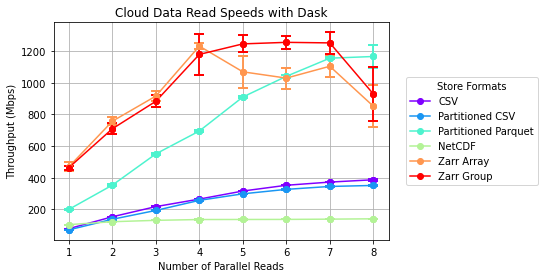

First, let us study the read speeds of the legacy file formats (CSV, Partitioned CSV, & NetCDF). Clearly they are significantly slower than the cloud-native counterparts, but show a relatively linear relationship. The errors are also extremely small when measured against the cloud-native formats, but does not warrant their use in big data anaylsis. In fact, the only purpose of including these legacy formats is to demonstrate how much slower they are than Parquet and Zarr. The read throughput is far too small for use in larger-scale testing but provides an interesting comparison in this local context.

Initial observations of read speed for the cloud native formats is promising given the large increase in throughput from CSV & NetCDF. The read also scales well up to 4 workers, after which some odd behavior is noticed. The large error and overall volatility of the Zarr format is unexpected. One hypothesis considers that the file size may be too small to allow a speedup past four workers, but this idea does not fully explain variation observed beyond this point. Another theory is that the local cluster simply doesn't allowing scaling to the level that will contain enough data points to show consistently increasing read speed. Using a distributed cluster of high-performance machines may provide the validation necessary to explain this behavior.

Parquet shows the most stable read throughput scaling of all formats, with a decrease in the throughput change rate as the test approaches eight workers. Like Zarr, this decrease in change rate may vanish when the benchmark is applied to a distributed HPC cluster and scaled up. All things considered, the Parquet format has the most stable read speed increase rate of the cloud-native formats, and is certainly a huge improvement from the traditional CSV format speeds.

This notebook is by no means a full representation of the capabilities of cloud-native data formats' ability to scale, so future tests with higher-performance hardware will be conducted in a separate notebook. However, this benchmarking is a great example of what one can expect when operating on a single machine and can help inform format decisions for work that requries the use of larger-than-memory data.

-------------------------------------------------------------------------------------------------------------------------------

## Imports & Client Initialization

In [ ]:
import dask.array as dsa
import numpy as np
import dask.dataframe as dd
from contextlib import contextmanager
import xarray as xr
import intake
import time
import dask
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.ticker import MaxNLocator
import matplotlib.colors
import pandas as pd
from scipy.stats import sem

In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(threads_per_worker=2)
client = Client(cluster)

## Benchmarking Setup

First, we will create this null storage object. To measure our throughput, all of the data will need to be accessed at a single time and can be achieved by storing the data into this null storage target.

In [ ]:
class DevNullStore:
    def __init__(self):
        pass
    def __setitem__(*args, **kwargs):
        pass

null_store = DevNullStore()

The Diagnostic Timer will keep track of data retrieval times and store them within a Pandas DataFrame for later processing and analysis.

In [ ]:
class DiagnosticTimer:
    def __init__(self):
        self.diagnostics = []
        self.names = []
        
    @contextmanager
    def time(self, **kwargs):
        tic = time.time()
        yield
        toc = time.time()
        kwargs["runtime"] = toc - tic
        self.diagnostics.append(kwargs)
        
    def dataframe(self):
        return pd.DataFrame(self.diagnostics)
    
diag_timer = DiagnosticTimer()

This naming function will keep track of our read throughput for each file format and make it easier to plot all of the cases.

In [ ]:
def name(fileType, daf): # Takes a string fileType input & dataframe type input for daf 
    globals()[f"df_{fileType}"] = daf
    diag_timer.names.append(globals()[f"df_{fileType}"])
    
    global df, da
    del df, da
    
    diag_timer.diagnostics = []

Information about our cluster is also collected during the tests. Importantly, the number of parallel reads will correspond to the total number of workers.

In [ ]:
def total_nthreads():
    return sum([v for v in client.nthreads().values()])

def total_ncores():
    return sum([v for v in client.ncores().values()])

def total_workers():
    return len(client.ncores())

This is the main loop. A few modifications have been made from Abernathey's original version, but most notably an error calculation has been added. In that case that the user wishes to run multiple tests for each file format, the `errorCalc(...)` function will calculate the error and the mean throughput for each file format.

In [ ]:
class mainLoop:
    def errorCalc(self, df1):
        global tests
        errors = []
        means = []
        info = []
        sample = df1['throughput_Mbps']
        for i in np.linspace(0, len(sample)-tests,int(len(sample)/tests), dtype='int'):
            temp = sample[slice(i,(i+tests))]
            errors.append(sem(temp))
            means.append(temp.mean())
            info.append(df1.iloc[i, 0:7])
        
        df0 = pd.DataFrame(info, index=range(len(info)))
        df0['throughput_Mbps'] = pd.DataFrame(means)
        df0['errors'] = pd.DataFrame(errors)
        return df0

    def loop(self, da, diag_kwargs):
        global tests, max_workers, worker_step
        nworkers = max_workers
        while nworkers > 0:
            cluster.scale(nworkers)
            time.sleep(10)
            client.wait_for_workers(nworkers)
            print('Number of Workers:', nworkers)
            for i in range(tests):
                with diag_timer.time(nworkers=total_workers(), nthreads=total_nthreads(), ncores=total_ncores(),
                                     **diag_kwargs):
                    future = dsa.store(da, null_store, lock=False, compute=False)
                    dask.compute(future, retries=5)
                del future   
            nworkers -= worker_step
        
        df = diag_timer.dataframe()
        df['throughput_Mbps'] = da.nbytes / 1e6 / df['runtime']
        if i != 0:
            df = self.errorCalc(df)
        return df

mainLoop = mainLoop()

## Perform Benchmarking

Though we are accessing the data from different formats, the core process will be the exact same. Dask is lazy by default, which means we will be using the previously defined null_store to measure throughput. Converting from DataFrames to Arrays, for example, will not affect the access speed because the data is not actually read from the source until we "store" it. So, these read speeds should be the same whether you are initially pointing to data using a dataframe or array.

###  User Input for Testing Conditions

Here, the user will define the testing benchmarking conditions:
* `tests = (int)` The number of times each individual file format will be read for measurement. Entering a number greater than 1 will take much longer to run, but results will include errors & throughput plot will have error bars.


* `max_workers = (int)` Maximum amount of parallel reads to be tested.


* `worker_step = (int)` Workers will be reduced by this number through each iteration of the main loop.


* `root = (string)` Root directory of the object storage location. Will be changed to a public URL when project bucket becomes public.

In [ ]:
tests = 1
max_workers = 8
worker_step = 2
root = 'gs://cloud-data-benchmarks/'

### CSV

This is the classic tabular data format. Students & professionals alike use this format due to its simplicity and flexibility bewteen applications. As you will see, this format has the slowest read times of all being tested but is included in the benchmarking given its widespread use.

#### Single File

In [ ]:
tic1 = time.time()
df0 = dd.read_csv(root + 'ETOPO1_Ice_g_gmt4.csv',assume_missing=True, names=['lon', 'lat', 'z'])
toc1 = time.time()
connectTime = toc1-tic1

da = df0.to_dask_array(lengths=True)
del df0
chunksize = np.prod(da.chunksize) * da.dtype.itemsize
da

In [ ]:
diag_kwargs = dict(nbytes=da.nbytes, chunksize=chunksize, format='CSV', connectTime=connectTime)

df = mainLoop.loop(da, diag_kwargs)
name('csv', df)
df_csv

#### Multiple Files

While one CSV file is the most common way one will see data of this format presented, we are interested in determining if partitioning (splitting up) the data into file sizes automatically determined by Dask will speed up the read from cloud storage. The process is the exact same, with the exception of a minor amount of required preprocessing.

In [ ]:
tic1 = time.time()
df0 = dd.read_csv(root + 'csvpartitions/*', assume_missing=True, names=['lon', 'lat', 'z'])
toc1 = time.time()
connectTime = toc1-tic1

da = df0.to_dask_array(lengths=True)
del df0
chunksize = np.prod(da.chunksize) * da.dtype.itemsize
da

In [ ]:
diag_kwargs = dict(nbytes=da.nbytes, chunksize=chunksize, format='Partitioned CSV', connectTime=connectTime)

df = mainLoop.loop(da, diag_kwargs)
name('partcsv', df)
df_partcsv

### Parquet

Throughput will be tested in two different ways:
* **Multiple Files:** A CSV file was partitioned into a DataFrame by Dask, and 1 parquet file was written per DataFrame partition. All of these files will be read into the null storage target
* **Single File:** A single parquet file containing all of the original CSV information will be read into the null storage target

#### Multiple Files

In [ ]:
tic1 = time.time()
df0 = dd.read_parquet(root + 'parquetpartitions/*')
toc1 = time.time()
connectTime = toc1 - tic1

da = df0.to_dask_array(lengths=True)
del df0
chunksize = np.prod(da.chunksize) * da.dtype.itemsize
da

In [ ]:
diag_kwargs = dict(nbytes=da.nbytes, chunksize=chunksize, format='Partitioned Parquet', connectTime=connectTime)

df = mainLoop.loop(da, diag_kwargs)
name('partparquet', df)
df_partparquet

#### Single File

**BE AWARE THAT THIS SINGLE PARQUET FILE WILL NOT RUN TO COMPLETION. THE KERNEL WILL HAVE TO BE RESET IF THE CELLS IN THIS SECTION ARE EXECUTED. SEE REASONING BELOW.**

We encounter a problem with large unmanaged memory when attempting to compute the size of DataFrame. This format is used here as an example of a file format that will not work in parallel, and should **only** be run to demonstrate a use case that does not function.

Generally, it is recommended that parquet files be partitioned in advance to avoid this issue. Dask currently creates DataFrame partitions based on the number of files stored within the parquet file path. Having one large file goes against the point of switching to parquet files in the first place because Dask will not be able to partition the data for parallel processing.

In [ ]:
tic1 = time.time()
df0 = dd.read_parquet(root + 'ETOPO1_Ice_g_gmt4.parquet')
toc1 = time.time()
connectTime = toc1 - tic1
# Memory Problem between these print statements, similar to the NetCDF issue
print("Calculating size of array")
da = df0.to_dask_array()
print("Size of array has been calculated")

del df0
chunksize = np.prod(da.chunksize) * da.dtype.itemsize
da

In [ ]:
diag_kwargs = dict(nbytes=da.nbytes, chunksize=chunksize, format='Parquet', connectTime=connectTime)

df = mainLoop.loop(da, diag_kwargs)
name('parquet', df)
df_parquet

### NetCDF

NetCDF files are extremely common in geospatial and climate science, which is the original format of the test data used in this benchmarking. Data from these fields are commonly very large, with sizes only increasing as missions collecting samples at higher resolutions are conducted. The informed scientist should have a good grasp on the speed limitations of this format and the best ways to load in and perform computations within Python.

We load the NetCDF using the `intake` library. This is a great way to load the data from GCS without directly using the `gcsfs` module. Depending on the NetCDF file contents, decoding the data using the engines included with `xarray.open_dataset(...)` can be troublesome. Read the XArray documentation about accessing files using `xarray.open_dataset(...)` [here](https://docs.xarray.dev/en/stable/user-guide/io.html).

The `intake` module is much easier to use, and offers some additional functionality in the form of catalogs. Read about catalogs and their uses [here](https://intake.readthedocs.io/en/latest/catalog.html).

In [ ]:
tic1 = time.time()
data = intake.open_netcdf(root + 'ETOPO1_Ice_g_gmt4.nc').to_dask()
toc1 = time.time()
connectTime = toc1-tic1
data = data.to_array()
da = data.data # Retrieves raw values from wrapped Xarray DataArray object
da = dsa.from_array(da)
chunksize = np.prod(da.chunksize) * da.dtype.itemsize
del data
da

In [ ]:
diag_kwargs = dict(nbytes=da.nbytes, chunksize=chunksize, format='NetCDF', connectTime=connectTime)

df = mainLoop.loop(da, diag_kwargs)
name('netcdf', df)
df_netcdf

### Zarr

Zarr Groups/Arrays are cloud-native gridded data formats, making them very useful for converting NetCDF files. It is known that there will be a large speedup with cloud read speed compared to the legacy data formats, but the performance differences between a Group/Array is important to note.

See <a href="https://www.programcreek.com/python/example/128207/dask.array.from_zarr#:~:text=.chunks)-,Example%205,-Project%3A%20napari">this python example</a> of `dask.array.from_zarr(...)` for further understanding of the differences between a Zarr Array & Zarr Group. A Zarr Group is a very good choice of storage utility for multiscale data due to its hierarchical paths in an object storage system -- this allows many different data sets to be stored in subdirectories under a larger Zarr store directory.

#### Zarr Array

In [ ]:
tic1 = time.time()
da = dsa.from_zarr(root + 'ETOPO1_Ice_g_gmt4.zarray')
toc1 = time.time()
connectTime = toc1 - tic1
chunksize = np.prod(da.chunksize) * da.dtype.itemsize
da

In [ ]:
diag_kwargs = dict(nbytes=da.nbytes, chunksize=chunksize, format='Zarr Array', connectTime=connectTime)

df = mainLoop.loop(da, diag_kwargs)
name('zarray', df)
df_zarray

#### Zarr Hierachical Group

Xarray provides a fantasic tool in their API for opening Zarr groups. By consolidating the metadata upon creation of the group, the read speed increases considerably more than if it was left in its base state.

In [ ]:
tic1 = time.time()
zarr_ds = xr.open_zarr(store= root + 'ETOPO1_Ice_g_gmt4.zarr', consolidated=True)
toc1 = time.time()
connectTime = toc1-tic1

darray = zarr_ds.to_array()
da = darray.data
del zarr_ds, darray

chunksize = np.prod(da.chunksize) * da.dtype.itemsize
da

In [ ]:
diag_kwargs = dict(nbytes=da.nbytes, chunksize=chunksize, format='Zarr Group', connectTime=connectTime)

df = mainLoop.loop(da, diag_kwargs)
name('zgroup', df)
df_zgroup

In [ ]:
client.close()
cluster.close()

## Plot Throughput

In [ ]:
class errorPlot:
    def plot(self):
        x = self.df['nworkers']
        y = self.df['throughput_Mbps']
        error = self.df['errors']
        plt.errorbar(x, y, yerr=error, color=self.c, fmt='o', capsize=5, capthick=2)
        
    def errorCheck(self, daf, color):
        self.c = color
        self.df = daf
        try:
            self.plot()
        except:
            pass
        else:
            self.plot()
            
errorPlot = errorPlot()

In [ ]:
color = cm.rainbow(np.linspace(0,1,len(diag_timer.names)))
legend = []

for i in range(len(diag_timer.names)):
    legend.append(diag_timer.names[i]['format'][1])
    c = color[i,:]
    c = matplotlib.colors.to_hex(c)
    
    if i==0:
        ax = diag_timer.names[i].plot(x='nworkers', y='throughput_Mbps', title='Cloud Data Read Speeds with Dask',
                                      kind='line', color=c, marker='o')
        errorPlot.errorCheck(diag_timer.names[i], c)
        
    elif i==(len(diag_timer.names)-1):
        diag_timer.names[i].plot(x='nworkers', y='throughput_Mbps', kind='line', color=c, ax=ax, 
                                 xlabel='Number of Parallel Reads', ylabel='Throughput (Mbps)', marker='o')
        errorPlot.errorCheck(diag_timer.names[i], c)
        plt.grid(True)
        plt.legend(legend, bbox_to_anchor=[1.25, 0.5], loc='center', title='Store Formats')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        #plt.yscale('symlog') ACTIVATE THIS LINE IF YOU ARE USING A LARGE AMOUNT OF WORKERS
    
    else:
        diag_timer.names[i].plot(x='nworkers', y='throughput_Mbps', kind='line', color=c, ax=ax, marker='o')
        errorPlot.errorCheck(diag_timer.names[i], c)